Python + numpy实现模型

In [173]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data49217  data64


In [174]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [175]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 19.5MB/s eta 0:00:01


In [176]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [177]:
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [178]:
def load_data():
    # 从文件导入数据
    datafile = '/home/aistudio/data/data49217/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [179]:
training_data, test_data = load_data()
x = training_data[:, :-1]
y = training_data[:, -1:]

In [180]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        #np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = 1. / N * np.sum((z-y) * x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = 1. / N * np.sum(z-y)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

In [181]:
# 获取数据
train_data, test_data = load_data()
x_train = train_data[:, :-1]
y_train = train_data[:, -1:]
x_test = test_data[:, :-1]
y_test = test_data[:, -1:]

In [182]:
# 创建网络
net = Network(13)

In [183]:
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)

Epoch   0 / iter   0, loss = 1.7729
Epoch   0 / iter   1, loss = 0.9943
Epoch   0 / iter   2, loss = 0.6020
Epoch   0 / iter   3, loss = 0.3522
Epoch   0 / iter   4, loss = 0.2023
Epoch   1 / iter   0, loss = 0.3149
Epoch   1 / iter   1, loss = 0.3655
Epoch   1 / iter   2, loss = 0.3521
Epoch   1 / iter   3, loss = 0.4300
Epoch   1 / iter   4, loss = 0.3956
Epoch   2 / iter   0, loss = 0.3531
Epoch   2 / iter   1, loss = 0.4585
Epoch   2 / iter   2, loss = 0.2286
Epoch   2 / iter   3, loss = 0.2584
Epoch   2 / iter   4, loss = 0.6880
Epoch   3 / iter   0, loss = 0.3030
Epoch   3 / iter   1, loss = 0.3476
Epoch   3 / iter   2, loss = 0.3002
Epoch   3 / iter   3, loss = 0.2667
Epoch   3 / iter   4, loss = 0.3141
Epoch   4 / iter   0, loss = 0.2708
Epoch   4 / iter   1, loss = 0.2440
Epoch   4 / iter   2, loss = 0.2904
Epoch   4 / iter   3, loss = 0.3238
Epoch   4 / iter   4, loss = 0.2590
Epoch   5 / iter   0, loss = 0.2723
Epoch   5 / iter   1, loss = 0.2499
Epoch   5 / iter   2, loss =

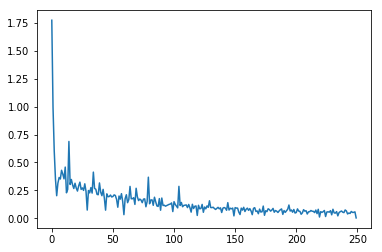

In [184]:
# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

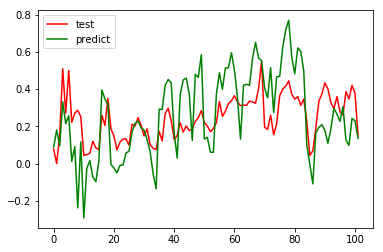

In [185]:
#画出真实值和预测值的曲线
t = np.arange(len(x_test))
y_predict = net.forward(x_test)
plt.plot(t,y_test,'r',label= 'test')
plt.plot(t,y_predict,'g',label= 'predict')
plt.legend()
plt.show()

In [186]:
#加载飞桨、Numpy和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random

In [187]:
def load_data():
    # 从文件导入数据
    datafile = '/home/aistudio/data/data49217/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [188]:
class Regressor(paddle.nn.Layer):

    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义一层全连接层，输入维度是13，输出维度是1
        self.fc = Linear(in_features=13, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc(inputs)
        return x

In [189]:
# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 加载数据
training_data, test_data = load_data()
# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.01
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())


In [190]:
EPOCH_NUM = 10   # 设置外层循环次数
BATCH_SIZE = 10  # 设置batch大小

# 定义外层循环
losses = []
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)
        
        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        losses.append(loss)
        avg_loss = paddle.mean(loss)
        if iter_id%20==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
        
        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

epoch: 0, iter: 0, loss is: [0.136552]
epoch: 0, iter: 20, loss is: [0.08623151]
epoch: 0, iter: 40, loss is: [0.40314192]
epoch: 1, iter: 0, loss is: [0.04426612]
epoch: 1, iter: 20, loss is: [0.16992335]
epoch: 1, iter: 40, loss is: [0.06998558]
epoch: 2, iter: 0, loss is: [0.03427515]
epoch: 2, iter: 20, loss is: [0.10638505]
epoch: 2, iter: 40, loss is: [0.00719206]
epoch: 3, iter: 0, loss is: [0.06770986]
epoch: 3, iter: 20, loss is: [0.0405423]
epoch: 3, iter: 40, loss is: [0.02521848]
epoch: 4, iter: 0, loss is: [0.08114425]
epoch: 4, iter: 20, loss is: [0.05919357]
epoch: 4, iter: 40, loss is: [0.01536326]
epoch: 5, iter: 0, loss is: [0.07074254]
epoch: 5, iter: 20, loss is: [0.04617733]
epoch: 5, iter: 40, loss is: [0.05307287]
epoch: 6, iter: 0, loss is: [0.06220507]
epoch: 6, iter: 20, loss is: [0.04059447]
epoch: 6, iter: 40, loss is: [0.03766714]
epoch: 7, iter: 0, loss is: [0.0384611]
epoch: 7, iter: 20, loss is: [0.04463588]
epoch: 7, iter: 40, loss is: [0.04470121]
epoc

In [191]:
# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), 'LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中


In [192]:
def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    idx = -10
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label

In [193]:
# 参数为保存模型参数的文件地址
model_dict = paddle.load('LR_model.pdparams')
model.load_dict(model_dict)
model.eval()

# 参数为数据集的文件地址
one_data, label = load_one_example()
# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)
# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))


Inference result is [[18.948505]], the corresponding label is 19.700000762939453
